In [1]:
import numpy
import qubit_matmul
import scipy.sparse
from matplotlib import pyplot
import os
import shadow_reconstruction

In [2]:
splus = numpy.array([
    [0.0, 0.0],
    [1.0, 0.0]
])
sminus = numpy.array([
    [0.0, 1.0],
    [0.0, 0.0]
])
sz = numpy.array([
    [-1.0, 0.0],
    [0.0, 1.0]
])
sn = numpy.array([
    [0.0, 0.0],
    [0.0, 1.0]
])

spm = numpy.kron(splus, sminus)
smp = numpy.kron(sminus, splus)
szz = numpy.kron(sz,sz)
szzzz = numpy.kron(szz,szz)
snn = numpy.kron(sn,sn)

def make_z(i):
    return qubit_matmul.TensorMatf64([i], sz.flatten())

def make_zz(i,j):
    return qubit_matmul.TensorMatf64([i,j], szz.flatten())

def make_zzzz(i,j,k,l):
    return qubit_matmul.TensorMatf64([i,j,k,l], szzzz.flatten())

def make_pm(i,j):
    return qubit_matmul.TensorMatf64([i, j], spm.flatten())

def make_pmpm(i,j,k,l):
    return qubit_matmul.TensorMatf64([i, j,k,l], numpy.kron(spm,spm).flatten())

In [3]:
def make_creutz_ladder_ham(l,mu=0.0, v=0.0, t0=0.0, t1=0.0):
    terms = []
    
    for i in range(l//2):
        a = 2*i
        b = 2*i + 1
        terms.extend([
            qubit_matmul.TensorMatc64([a], (mu * sn).flatten().astype(numpy.complex128)),
            qubit_matmul.TensorMatc64([b], (mu * sn).flatten().astype(numpy.complex128))
        ])
        
        aa = a + 2
        bb = b + 2
        if aa < l and bb < l:
            terms.extend([
                # Number number
                qubit_matmul.TensorMatc64([a,aa], (v * snn).flatten().astype(numpy.complex128)),
                qubit_matmul.TensorMatc64([b,bb], (v * snn).flatten().astype(numpy.complex128)),
                qubit_matmul.TensorMatc64([a,bb], (v * snn).flatten().astype(numpy.complex128)),
                qubit_matmul.TensorMatc64([aa,b], (v * snn).flatten().astype(numpy.complex128)),
                # Hopping upper and lower
                qubit_matmul.TensorMatc64([a,aa], (-1.0j * t1 * smp).flatten().astype(numpy.complex128)),
                qubit_matmul.TensorMatc64([a,aa], (1.0j * t1 * spm).flatten().astype(numpy.complex128)),
                qubit_matmul.TensorMatc64([b,bb], (1.0j * t1 * smp).flatten().astype(numpy.complex128)),
                qubit_matmul.TensorMatc64([b,bb], (-1.0j * t1 * spm).flatten().astype(numpy.complex128)),
                # Hopping cross
                qubit_matmul.TensorMatc64([b,aa], (-1.0 * t0 * smp).flatten().astype(numpy.complex128)),
                qubit_matmul.TensorMatc64([b,aa], (-1.0 * t0 * spm).flatten().astype(numpy.complex128)),
                qubit_matmul.TensorMatc64([a,bb], (-1.0 * t0 * smp).flatten().astype(numpy.complex128)),
                qubit_matmul.TensorMatc64([a,bb], (-1.0 * t0 * spm).flatten().astype(numpy.complex128)),
            ])
            
    acc = terms[0]
    for t in terms[1:]:
        acc = acc + t
    return acc

In [4]:
def make_ladder_ham(l,mu=0.0, v=1.0, trung=0.0, trail=0.0, periodic=False):
    n = (mu * sn).flatten().astype(numpy.complex128)
    nn = (v * numpy.kron(sn,sn)).flatten().astype(numpy.complex128)
    rung_hop = ((trung * spm) + numpy.conj(trung * smp)).flatten().astype(numpy.complex128)
    rail_hop = ((trail * spm) + numpy.conj(trail * smp)).flatten().astype(numpy.complex128)
    
    terms = []
    
    for i in range(l//2):
        a = 2*i
        b = 2*i + 1
        terms.extend([
            qubit_matmul.TensorMatc64([a], n),
            qubit_matmul.TensorMatc64([b], n),
            qubit_matmul.TensorMatc64([a,b], rung_hop),
            qubit_matmul.TensorMatc64([a,b], nn)
        ])
        
        aa = a + 2
        bb = b + 2
        if periodic:
            aa = aa % l
            bb = bb % l
        
        if aa < l and bb < l:
            terms.extend([
                # Hopping upper and lower
                qubit_matmul.TensorMatc64([a,aa], rail_hop),
                qubit_matmul.TensorMatc64([b,bb], rail_hop),
            ])
            
    acc = terms[0]
    for t in terms[1:]:
        acc = acc + t
    return acc

In [5]:
def make_data(l,hermitian=False,k=4,**kwargs):
    ham = make_ladder_ham(l,**kwargs)
    row, col, data = ham.make_sparse(l)
    ham = scipy.sparse.csr_array((data, (row, col)), shape=(1<<l,1<<l))
    vals, vecs = scipy.sparse.linalg.eigsh(ham,k=k,which='SA')
    assert vals[0] == min(vals)
    gse = vals[0]
    print(gse)
    gs = vecs[:,0]
    
#     Check half filling
    data = []
    for i,x in enumerate(gs):
        if abs(x) > 1e-10:
            data.append(bin(i)[2:].zfill(l).count('1'))
    print(data[0])
#     assert(all(map(lambda x: x==l//2, data)))

    zz_corrs = []
    zz_xcorr = numpy.arange(2,l,2)
    for r in zz_xcorr:
        corr_check = make_zz(0,r).get_sparse(l)
        ground_truth = numpy.conj(gs) @ (corr_check @ gs)
        zz_corrs.append(ground_truth)
    zz_data = (zz_xcorr, numpy.array(zz_corrs))
    
    zzzz_corrs = []
    zzzz_xcorr = numpy.arange(2,l,2)
    for r in zzzz_xcorr:
        corr_check = make_zzzz(0,1,r,r+1).get_sparse(l)
        ground_truth = numpy.conj(gs) @ (corr_check @ gs)
        zzzz_corrs.append(ground_truth)
    zzzz_data = (zzzz_xcorr, numpy.array(zzzz_corrs))

    corrs = []
    xcorr = numpy.arange(2,l,2)
    for r in xcorr:
        corr_check = make_pm(0,r).get_sparse(l)
        if hermitian:
            corr_check = corr_check + corr_check.T
        ground_truth = numpy.conj(gs) @ (corr_check @ gs)
        corrs.append(ground_truth)
    pm_data = (xcorr, numpy.array(corrs))
        
    pair_corrs = []
    xpaircorr = numpy.arange(2,l,2)
    for r in xpaircorr:
        corr_check = make_pmpm(0,r,1,r+1).get_sparse(l)
        if hermitian:
            corr_check = corr_check + corr_check.T
        ground_truth = numpy.conj(gs) @ (corr_check @ gs)
        pair_corrs.append(ground_truth)
    ppmm_data = (xpaircorr, numpy.array(pair_corrs))
    
    return gs, zz_data, zzzz_data, pm_data, ppmm_data

In [6]:
l = 20
gs, (xz, zz), (xzz, zzzz), (xpm, pm), (xppmm, ppmm) = make_data(l,mu=1.75,v=-3.0,trail=0.5j,trung=0.1j,periodic=False,hermitian=True)

-0.13746922161865788
4


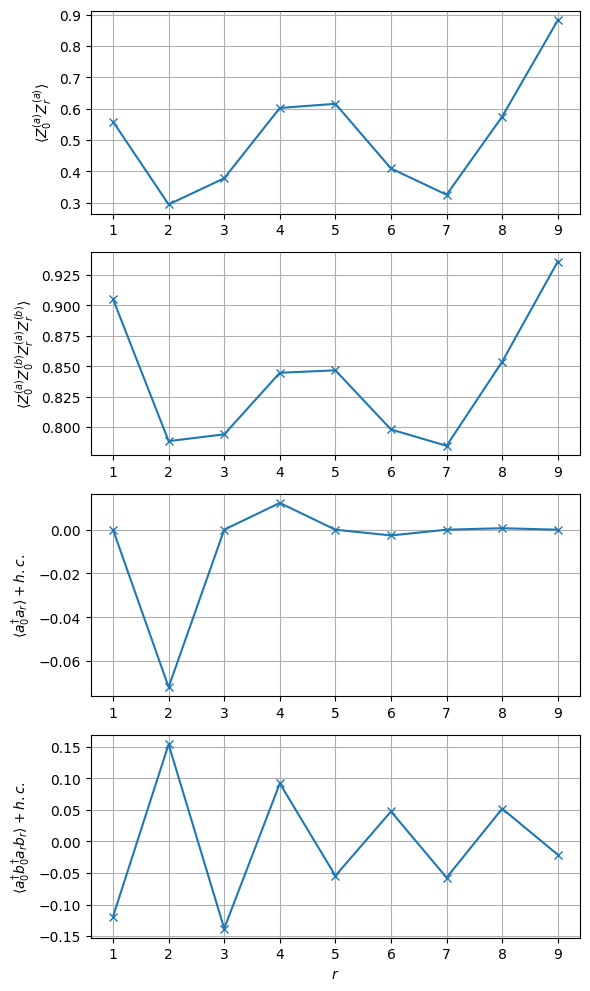

In [7]:
fig, axs = pyplot.subplots(4, figsize=(6,10))

axs[0].plot(xz/2, zz.real,'x-')
axs[0].grid()
axs[0].set_ylabel(r'$\langle Z^{(a)}_0 Z^{(a)}_r \rangle$')

axs[1].plot(xzz/2, zzzz.real,'x-')
axs[1].grid()
axs[1].set_ylabel(r'$\langle Z^{(a)}_0 Z^{(b)}_0 Z^{(a)}_r Z^{(b)}_r \rangle$')

axs[2].plot(xpm/2, pm.real,'x-')
axs[2].grid()
axs[2].set_ylabel(r'$\langle a_0^{\dagger} a_r \rangle + h.c.$')

axs[3].plot(xppmm/2, ppmm.real,'x-')
axs[3].grid()
axs[3].set_ylabel(r'$\langle a_0^{\dagger}b_0^{\dagger} a_r b_r \rangle + h.c.$')
axs[3].set_xlabel(r'$r$')

fig.tight_layout()
pyplot.savefig('/tmp/plots1.jpeg')
pyplot.show()

In [8]:
l = 20
gs, (xz, zz), (xzz, zzzz), (xpm, pm), (xppmm, ppmm) = make_data(l,mu=1.75,v=-3.0,trail=0.5,trung=0.1,periodic=False,hermitian=True)

-0.13746922161865763
4


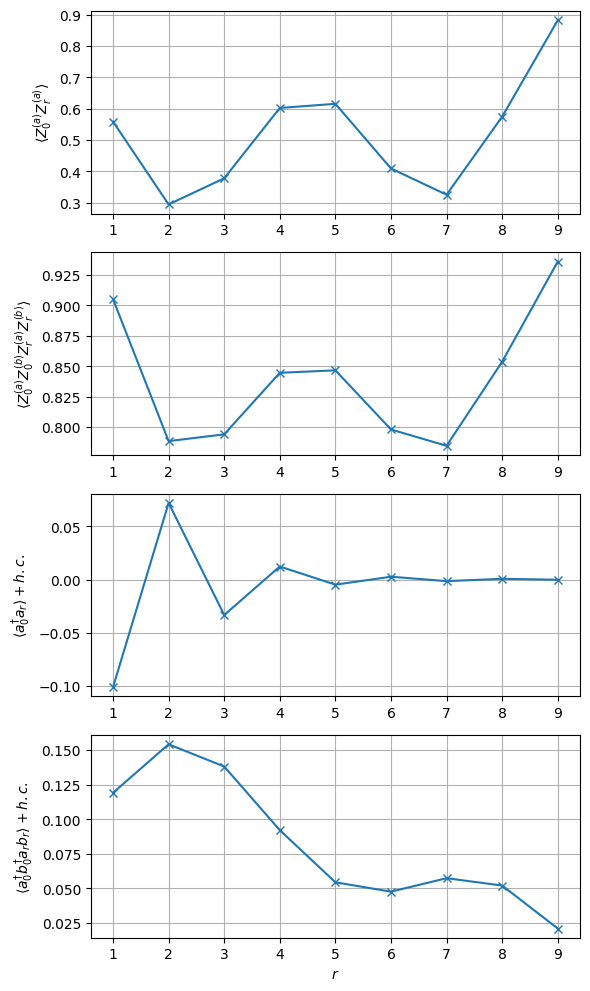

In [9]:
fig, axs = pyplot.subplots(4, figsize=(6,10))

axs[0].plot(xz/2, zz.real,'x-')
axs[0].grid()
axs[0].set_ylabel(r'$\langle Z^{(a)}_0 Z^{(a)}_r \rangle$')

axs[1].plot(xzz/2, zzzz.real,'x-')
axs[1].grid()
axs[1].set_ylabel(r'$\langle Z^{(a)}_0 Z^{(b)}_0 Z^{(a)}_r Z^{(b)}_r \rangle$')

axs[2].plot(xpm/2, pm.real,'x-')
axs[2].grid()
axs[2].set_ylabel(r'$\langle a_0^{\dagger} a_r \rangle + h.c.$')

axs[3].plot(xppmm/2, ppmm.real,'x-')
axs[3].grid()
axs[3].set_ylabel(r'$\langle a_0^{\dagger}b_0^{\dagger} a_r b_r \rangle + h.c.$')
axs[3].set_xlabel(r'$r$')

fig.tight_layout()
pyplot.savefig('/tmp/plots2.jpeg')
pyplot.show()

In [10]:
l = 20
gs, (xz, zz), (xzz, zzzz), (xpm, pm), (xppmm, ppmm) = make_data(l,mu=1.75,v=-3.0,trail=-0.5,trung=-0.1,periodic=False,hermitian=True)

-0.13746922161865888
4


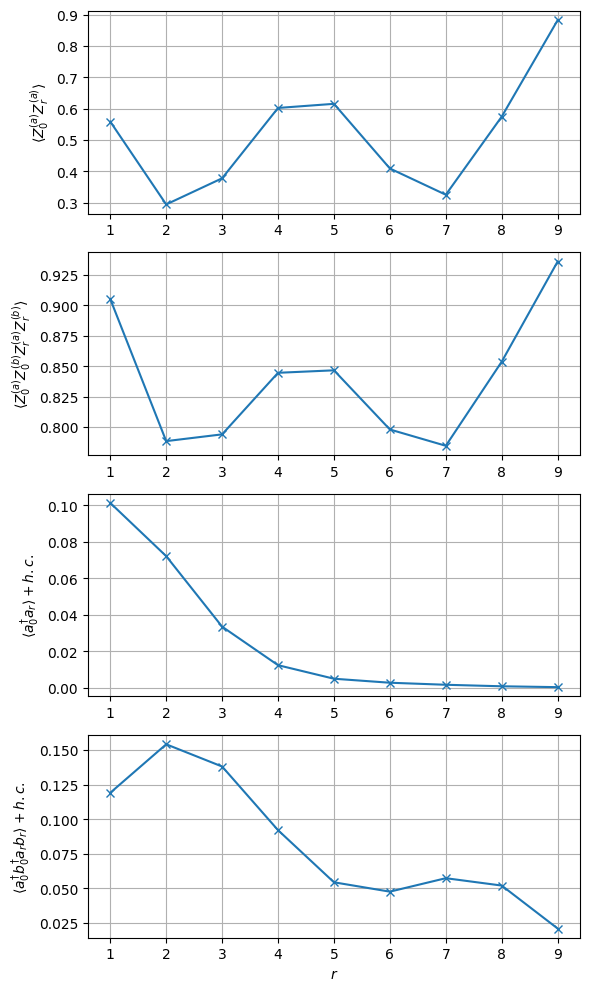

In [11]:
fig, axs = pyplot.subplots(4, figsize=(6,10))

axs[0].plot(xz/2, zz.real,'x-')
axs[0].grid()
axs[0].set_ylabel(r'$\langle Z^{(a)}_0 Z^{(a)}_r \rangle$')

axs[1].plot(xzz/2, zzzz.real,'x-')
axs[1].grid()
axs[1].set_ylabel(r'$\langle Z^{(a)}_0 Z^{(b)}_0 Z^{(a)}_r Z^{(b)}_r \rangle$')

axs[2].plot(xpm/2, pm.real,'x-')
axs[2].grid()
axs[2].set_ylabel(r'$\langle a_0^{\dagger} a_r \rangle + h.c.$')

axs[3].plot(xppmm/2, ppmm.real,'x-')
axs[3].grid()
axs[3].set_ylabel(r'$\langle a_0^{\dagger}b_0^{\dagger} a_r b_r \rangle + h.c.$')
axs[3].set_xlabel(r'$r$')

fig.tight_layout()
pyplot.savefig('/tmp/plots3.jpeg')
pyplot.show()